<a href="https://colab.research.google.com/github/Eddy-Emmanuel/Sequence-Classification/blob/main/Transformer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from datasets import load_dataset, Dataset, DatasetDict
except:
    !pip install datasets
    from datasets import load_dataset, Dataset, DatasetDict

from wordcloud import WordCloud

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
from transformers import TrainingArguments, Trainer
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [2]:
data = load_dataset("brackozi/Resume")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

UpdatedResumeDataSet.csv:   0%|          | 0.00/3.06M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/962 [00:00<?, ? examples/s]

In [3]:
data.set_format("pandas")

In [4]:
data_df = data["train"].to_pandas()

data_df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \nMay 2013 to May 2017 B.E ...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \n MCA YMCAUST, Faridabad..."


In [5]:
encoder = LabelEncoder()

data_df["enc_category"] = encoder.fit_transform(data_df["Category"])

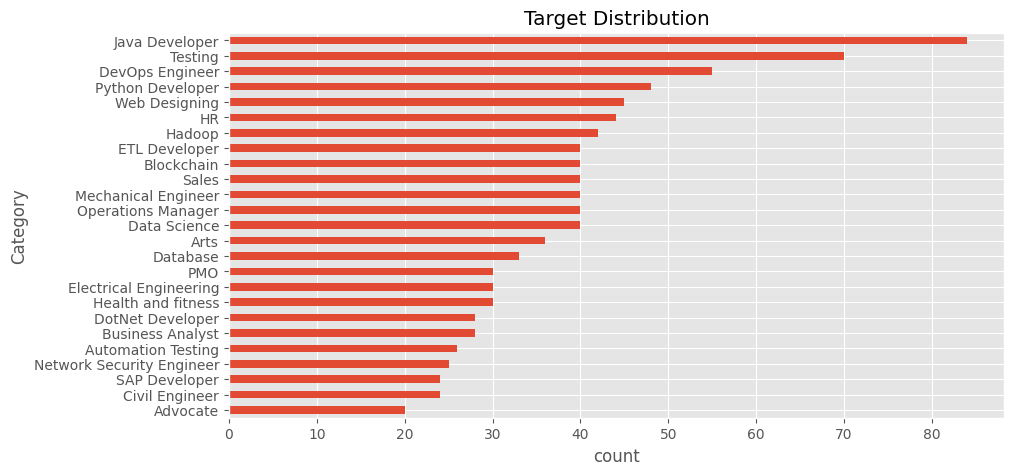

In [6]:
data_df["Category"].value_counts(ascending=True).plot(kind="barh",
                                                      figsize=(10, 5),
                                                      xlabel="count",
                                                      title="Target Distribution",
                                                      ylabel="Category")

plt.show()

In [7]:
data_df["sent_count"] = data_df["Resume"].str.split().apply(len)

<ipython-input-8-3a820035c2f0>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(labels=plt.gca().get_xticklabels(), rotation=90)


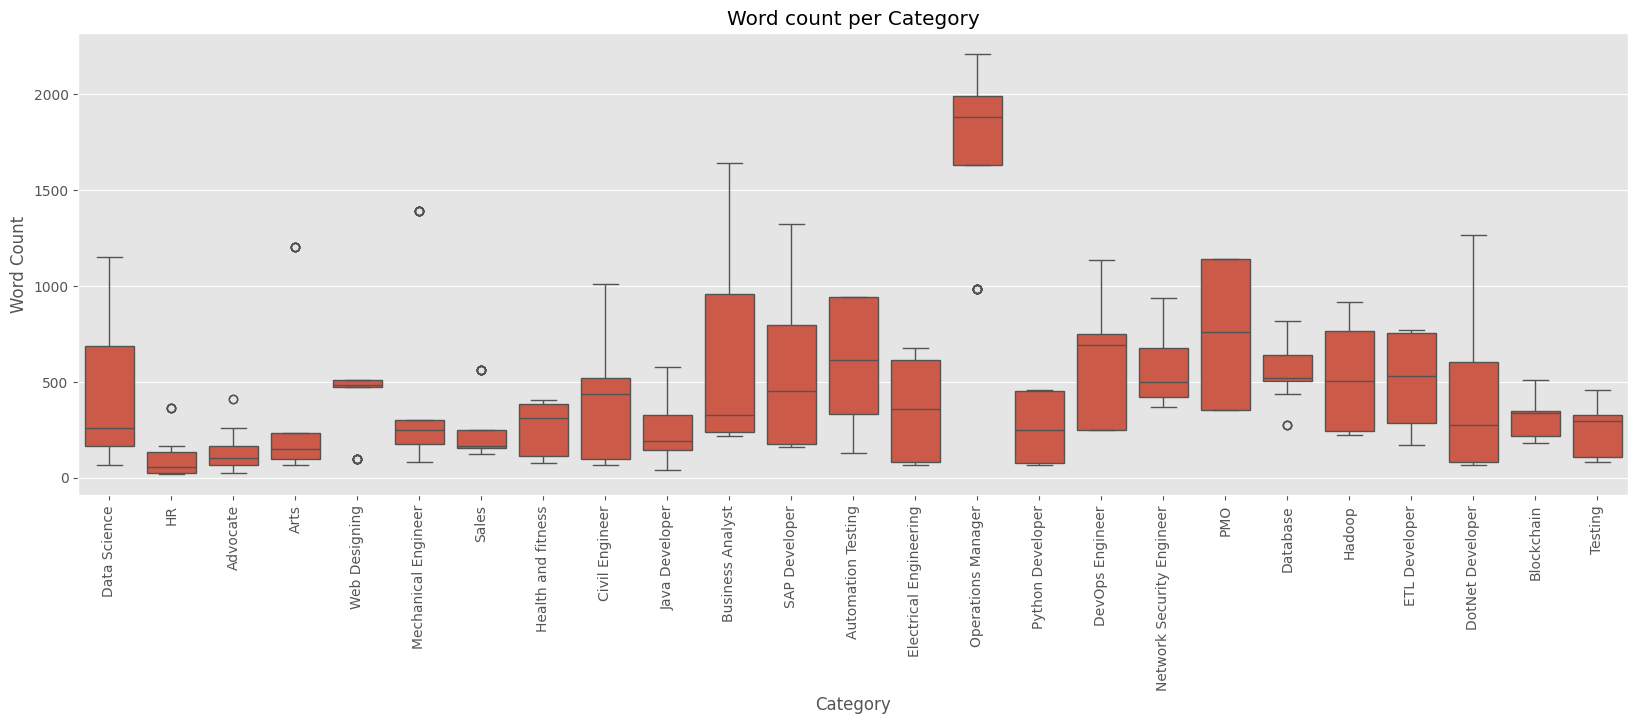

In [8]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=data_df, y="sent_count", x="Category")
plt.gca().set_xticklabels(labels=plt.gca().get_xticklabels(), rotation=90)
plt.title("Word count per Category")
plt.xlabel("Category")
plt.ylabel("Word Count")
plt.show()

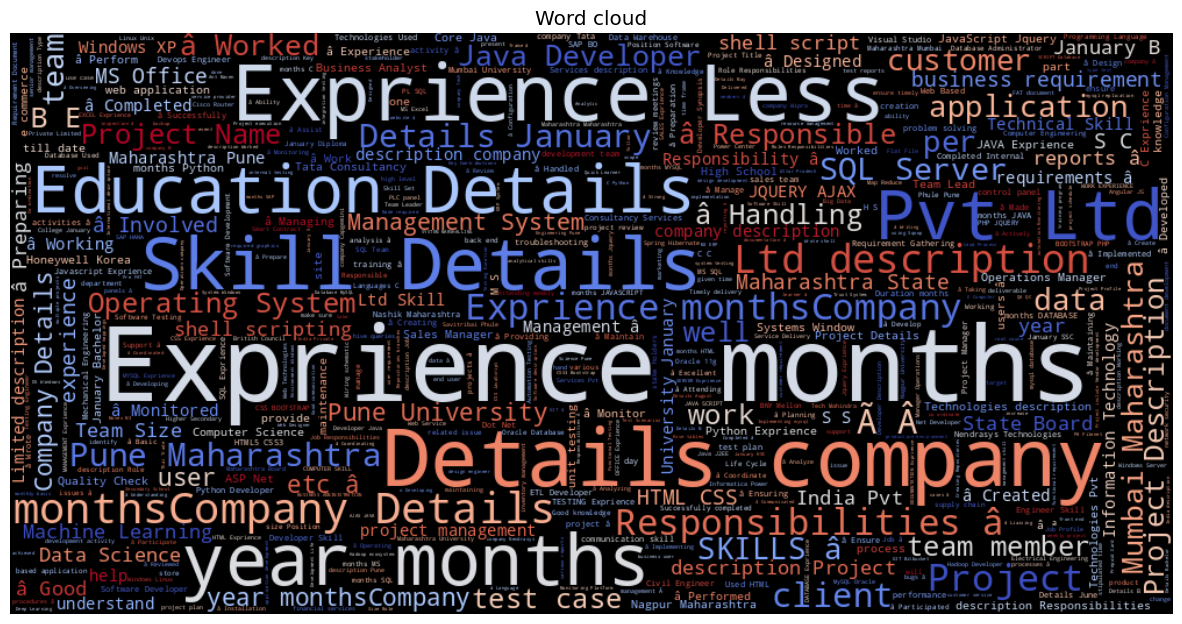

In [9]:
wordcloud = WordCloud(width=1000,
                      height=500,
                      max_words=data_df.shape[0],
                      colormap='coolwarm',
                      contour_color='blue',
                      contour_width=2).generate(" ".join(data_df["Resume"]))

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word cloud")
plt.show()

In [17]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
Xtrain, Xval, ytrain, yval = train_test_split(data_df["Resume"], data_df["enc_category"], test_size=0.2, stratify=data_df["enc_category"])
Xval, Xtest, yval, ytest = train_test_split(Xval, yval, test_size=0.2, stratify=yval)

print(Xtrain.shape, Xval.shape, Xtest.shape)

(769,) (154,) (39,)


### Pytorch

In [11]:
train_dataset = Dataset.from_pandas(pd.concat([Xtrain, ytrain], axis=1).reset_index(drop=True))
val_dataset = Dataset.from_pandas(pd.concat([Xval, yval], axis=1).reset_index(drop=True))
test_dataset = Dataset.from_pandas(pd.concat([Xtest, ytest], axis=1).reset_index(drop=True))

In [12]:
data_dict = DatasetDict({"train": train_dataset,
                         "val": val_dataset,
                         "test": test_dataset})

data_dict

DatasetDict({
    train: Dataset({
        features: ['Resume', 'enc_category'],
        num_rows: 769
    })
    val: Dataset({
        features: ['Resume', 'enc_category'],
        num_rows: 154
    })
    test: Dataset({
        features: ['Resume', 'enc_category'],
        num_rows: 39
    })
})

In [ ]:
tokenized_data = data_dict.map(lambda x: tokenizer(x["Resume"], truncation=True, padding=True), batched=True)

tokenized_data

Map:   0%|          | 0/769 [00:00<?, ? examples/s]

Map:   0%|          | 0/154 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Resume', 'enc_category', 'input_ids', 'attention_mask'],
        num_rows: 769
    })
    val: Dataset({
        features: ['Resume', 'enc_category', 'input_ids', 'attention_mask'],
        num_rows: 154
    })
    test: Dataset({
        features: ['Resume', 'enc_category', 'input_ids', 'attention_mask'],
        num_rows: 39
    })
})

In [ ]:
tokenized_data_prep = tokenized_data.remove_columns(["Resume"]).rename_column("enc_category", "label")

tokenized_data_prep

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 769
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 154
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 39
    })
})

In [ ]:
def model_evaluation_metrics(pred):
    ytrue, ypred = pred.label_ids, np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred, average="weighted")
    recall = recall_score(ytrue, ypred, average="weighted")
    f1 = f1_score(ytrue, ypred, average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    disable_tqdm=False,
    remove_unused_columns=True
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                            num_labels=len(set(tokenized_data["train"]["enc_category"])))

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tokenized_data_prep["train"],
                  eval_dataset=tokenized_data_prep["val"],
                  compute_metrics= model_evaluation_metrics,
                  processing_class = tokenizer)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,3.180900,3.088951,0.155844,0.063572,0.155844,0.064819
2,3.031600,2.897903,0.240260,0.164201,0.240260,0.142194
3,2.835800,2.661685,0.396104,0.400834,0.396104,0.313072
4,2.579700,2.421502,0.558442,0.602614,0.558442,0.502839
5,2.353000,2.159977,0.714286,0.736725,0.714286,0.666583
6,2.125400,1.914884,0.818182,0.823433,0.818182,0.784268
7,1.806400,1.687688,0.870130,0.887349,0.870130,0.853147
8,1.633700,1.485345,0.922078,0.918074,0.922078,0.904228
9,1.467000,1.312904,0.961039,0.967378,0.961039,0.954859
10,1.356800,1.160109,0.993506,0.993939,0.993506,0.993155


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=260, training_loss=1.5447618044339693, metrics={'train_runtime': 763.1863, 'train_samples_per_second': 20.152, 'train_steps_per_second': 0.341, 'total_flos': 2038184255385600.0, 'train_loss': 1.5447618044339693, 'epoch': 20.0})

In [ ]:
pd.DataFrame([trainer.evaluate(tokenized_data_prep["test"])])

,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.573871,1.0,1.0,1.0,1.0,0.6142,63.499,1.628,20.0
